# Lab 2: Debug a Broken Vanilla GAN (find 12+ issues)

In [1]:
import torch, torchvision, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.1307, 0.3081)])   # BUG normalize
loader=DataLoader(torchvision.datasets.MNIST('./data',True,download=True,transform=transform),batch_size=256,shuffle=True,num_workers=2,pin_memory=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.95MB/s]


In [13]:
z_dim=100; g_lr=2e-2; d_lr=2e-5
class D(nn.Module):
    def __init__(self):
        super().__init__(); self.net=nn.Sequential(nn.Conv2d(1,32,4,2,1) , # 14
                                                   nn.LeakyReLU(0.2,True),
                                                   nn.Conv2d(32,64,4,2,1), # 7
                                                   nn.BatchNorm2d(64),
                                                   nn.LeakyReLU(0.2,True),
                                                   nn.Conv2d(64,1,7,1,0),
                                                  #  nn.AdaptiveAvgPool2d(1),
                                                   nn.Flatten(),
                                                   )
    def forward(self,x):return self.net(x)
class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_dim = 100
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 4, 1, 0),  # (N,128,4,4)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),     # (N,64,8,8)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),      # (N,32,16,16)
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 1, 3, 2, 2),       # (N,1,28,28)
            nn.Tanh()
        )

    def forward(self,z):
      return self.net(z)
Dnet=D().to(device); Gnet=G().to(device)
crit=nn.BCEWithLogitsLoss(); opt_d=torch.optim.Adam(Dnet.parameters(),lr=d_lr,betas=(0.9,0.999)); opt_g=torch.optim.Adam(Gnet.parameters(),lr=g_lr,betas=(0.9,0.999))

In [19]:
from tqdm import tqdm
for real,_ in tqdm(loader):
    real=real.to(device); b=real.size(0)
    z=torch.randn(b,z_dim,device=device)
    fake=Gnet(z.view(b,z_dim,1,1))
    loss_d=crit(Dnet(real),torch.zeros(b,1,device=device))+crit(Dnet(fake),torch.ones(b,1,device=device))  # BUG labels
    opt_d.zero_grad();loss_d.backward(); opt_d.step()  # BUG
    z=torch.randn(b,z_dim,device=device)
    fake=Gnet(z.view(b,z_dim,1,1))
    loss_g=crit(Dnet(fake),torch.zeros(b,1,device=device))  # BUG non-sat
    opt_g.zero_grad()
    loss_g.backward()  # BUG missing step
    opt_g.step()
print('Now fix all the issues.')

  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 235/235 [03:47<00:00,  1.03it/s]

Now fix all the issues.


In [ ]:
from tqdm import tqdm
for e in range(30):
  for real,_ in tqdm(loader):
      real=real.to(device); b=real.size(0)
      z=torch.randn(b,z_dim,device=device)
      fake=Gnet(z.view(b,z_dim,1,1))
      loss_d=crit(Dnet(real),torch.zeros(b,1,device=device))+crit(Dnet(fake),torch.ones(b,1,device=device))  # BUG labels
      opt_d.zero_grad();loss_d.backward(); opt_d.step()  # BUG
      z=torch.randn(b,z_dim,device=device)
      fake=Gnet(z.view(b,z_dim,1,1))
      loss_g=crit(Dnet(fake),torch.zeros(b,1,device=device))  # BUG non-sat
      opt_g.zero_grad()
      loss_g.backward()  # BUG missing step
      opt_g.step()

  0%|          | 0/235 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 49%|████▊     | 114/235 [01:48<01:52,  1.07it/s]

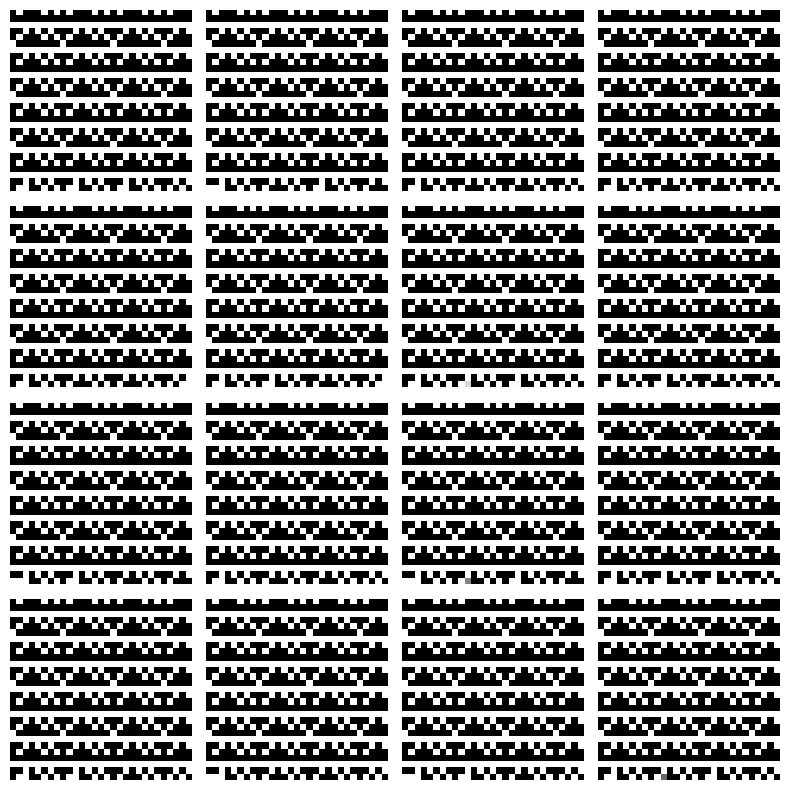

In [17]:
import matplotlib.pyplot as plt

# Generate some images
with torch.no_grad():
    z = torch.randn(16, z_dim, device=device)
    fake_images = Gnet(z.view(16, z_dim, 1, 1)).cpu()

# Display the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()